In [2]:
%run 'testSkeleton_OQE_Functions.ipynb'


In [183]:
s = 120
nu_max, nu_min = 120, 100 # MHz units
inprange = nu_max - nu_min
nu_ = np.linspace(nu_min,nu_max,s)
nu, nup = np.meshgrid(nu_,nu_)
tau_ = np.fft.fftfreq(s, (nu_max-nu_min)/(s-1))
tau_f = flip(tau_)
print(tau_f[0:5])

[-2.975      -2.92541667 -2.87583333 -2.82625    -2.77666667]


In [4]:
from scipy import linalg
from scipy.stats import invgamma
import pyuvdata as uvd
uvobj = uvd.UVData()

In [5]:
FO = FOp(s)

In [214]:
at1,at2 = 0,1
simfile = '/home/kennedy/sims/viscatBCpoints.uvh5'
faintfile = '/home/kennedy/sims/viscatBC15jy.uvh5'
oldsimfile = '/home/kennedy/sims/600times/viscatBCpoints.uvh5'
oldeorfile = '/home/kennedy/sims/600times/viscatBCeor.uvh5'
ats = (at1, at2)

uvobj.read(simfile)
bl = uvobj.get_data(ats)
C_f = np.cov(bl.T)
uvobj.read(oldsimfile)
bl6 = uvobj.get_data(ats)
C_f6 = np.cov(bl6.T)
uvobj.read(oldeorfile)
eor = uvobj.get_data(ats)
C_eor = np.cov(eor.T)
uvobj.read(faintfile)
blfaint = uvobj.get_data(ats)
C_faint = np.cov(blfaint.T)

C_fi = np.linalg.inv(C_f)
C_fainti = np.linalg.inv(C_faint)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [7]:
rfi2 = np.load('rfi2.npy')
rfi5 = np.load('rfi5.npy')
rfi10 = np.load('rfi10.npy')

w0,w1,w2,w3 = np.ones((s,)),np.ones((s,)),np.ones((s,)),np.ones((s,))
w1[rfi2],w2[rfi5],w3[rfi10] = 0,0,0

wc1,wc2,wc3 = np.ones((s,)),np.ones((s,)),np.ones((s,))
wc1[40:42], wc2[40:46], wc3[40:52] = 0,0,0 

In [348]:
SNR = 3
As, ws, k = 25e-2, 0.5, 25e-3/SNR
gc = As/1e1

C_signal = (gc*np.eye(s) + As * np.exp( -(nu-nup)**2 / ws**2  )) 
C_sig_delay = np.eye(s) * np.diag((FO @ C_signal @ FO.T.conj()).real)
C_signalcirc = (FO.T.conj()@ C_sig_delay @ FO).real / s**2

C_noise = k * np.eye(s) 

S = C_signal+C_f
N = C_noise
mv = np.zeros(s)
R = np.diag(BH(s))

In [264]:
# plt.matshow(np.log10(C_signalcirc))
# plt.colorbar()

In [349]:
Np = 1200 # number of data

truesigs = nsample(mv, C_signalcirc, Np)

# signaltouse = eor
signaltouse = truesigs

Vft = bl[:Np] + signaltouse 

noiseS = (nsample(mv, C_noise, Np) + 1j*nsample(mv, C_noise, Np))/2**0.5
Vis_noise = Vft + noiseS # noisy data generated

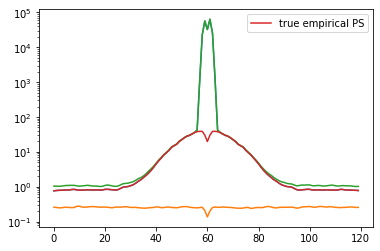

In [350]:
# signal and noise spectra for later comparison
pS = naivePS(Vft, meansub=1, taper=1)
pSsig = naivePS(signaltouse, meansub=1, taper=1)

# true (empirical) power spectrum - mean over signal power spectra
tps = np.mean(pSsig, axis=0).real
# psttt = naivePS(signaltouse, meansub=1, taper=0)

pSnoise = naivePS(noiseS, meansub=1, taper=1)
pSdata = naivePS(Vis_noise, meansub=1, taper=1)
plt.plot(np.mean(pS, axis=0))
plt.plot(np.mean(pSnoise, axis=0))
plt.plot(np.mean(pSdata, axis=0))
plt.plot(tps, label='true empirical PS')
# plt.plot(np.mean(psttt, axis=0))
plt.yscale('log')
plt.legend()

In [284]:
def sample_S(s=None, sk=None, prior=None):
    """
    Draw samples of the bandpowers of S, p(S|s). This assumes that the conditional 
    distribution for the bandpowers are uncorrelated with one another, i.e. the Fourier-
    space covariance S has no off-diagonals.
    
    Parameters:
        s (array_like):
            A set of real-space samples of the field, of shape (Ntimes, Nfreq).
    """
    if s is None and sk is None:
        raise ValueError("Must pass in s (real space) or sk (Fourier space) vector.")

    if sk is None:
        sk = np.fft.fft(s, axis=-1) 
    Nobs, Nfreqs = sk.shape
    
    beta = np.sum(sk * sk.conj(), axis=0).real 
    
    alpha = Nobs/2. - 1.
    
    x = np.zeros(Nfreqs)
    for i in range(Nfreqs):
        x[i] = invgamma.rvs(a=alpha) * beta[i] # y = x / beta
    
    
    
    if prior is not None:
        for i in range(Nfreqs):
            if prior[0,i] ==0: continue
            else: 
                if x[i] > prior[0,i]:  x[i] = prior[0,i]
                if x[i] < prior[1,i]:  x[i] = prior[1,i]
                    
    return x

In [285]:
def sprior(signals, bins, factor):
    
    # bins - number of bins past zero delay to take, either side. e.g. bins=2 takes delays [-2,-1,0,1,2] from centre
    # factor is maximum factor to multiply / divide the truth by
    
    Nobs,Nfreq = signals.shape
     
    ds = nPS(signals)
    
#     sk = np.fft.fft(signals, axis=-1)
#     ds = np.sum(sk * sk.conj(), axis=0).real
    
    prior = np.zeros((2,Nfreq))
    
    prior[0] = ds*factor
    prior[1] = ds/factor
    
    prior[0,bins+1:-bins] = 0
    prior[1,bins+1:-bins] = 0
    
    return prior/(Nobs/2 -1)

In [286]:
def makeS(delayspec):
    
    N_freq = delayspec.size
    
    C_sigfft = np.zeros((N_freq, N_freq), dtype=complex)
    
    for i in range(N_freq):
        C_sigfft[i,i] = delayspec[i]
        
    FO = np.zeros((N_freq,N_freq), dtype=complex)
    for i in range(N_freq):
        FO[i] = m(i,N_freq)
    
    C_sig = (FO.T.conj() @ C_sigfft @ FO).real
    
    return C_sig

In [287]:
def GCR_joint(dat, w, matlib, f0=None):
    """
    
    GCR w/ joint foreground sampling
    
#     matlib[0]: Sh = sp.linalg.sqrtm( S )...etc.
#     Fh = sp.linalg.sqrtm( F )
#     Si = np.linalg.inv( S )
#     Fi = np.linalg.inv( F )
#     Ni = w.T*np.linalg.inv( N )*w
#     Sih = sp.linalg.sqrtm( Si )
#     Fih = sp.linalg.sqrtm( Fi )
#     Nih = sp.linalg.sqrtm( Ni )
    
    """
    s = S.shape[0]
            
    d = dat.reshape((1,max(s,len(dat.T))))

    Sh = matlib[0][0]
    Si = matlib[0][1]
    Fi = matlib[0][2]
    Ni = matlib[0][3]
    Sih = matlib[0][4]
    Fih = matlib[0][5]
    Nih = matlib[0][6]
    A = matlib[1][0]
    Ai = matlib[1][1]
    
    omi, omj, omk = np.random.randn(s,1),np.random.randn(s,1),np.random.randn(s,1)
    oml, omm, omn = np.random.randn(s,1),np.random.randn(s,1),np.random.randn(s,1)
    oma, omb, omc = (omi+1j*omj)/2**0.5 , (omk+1j*oml)/2**0.5 , (omm+1j*omn)/2**0.5 # added a third for different 
                                                                                    # omegas for signal + fg

    b = np.zeros((2*s,1), dtype=complex)

    b[:s] = Ni @ (w*d).T + Sih@oma + Nih @ omb  
    
    if f0 is not None:
        b[s:] = Ni @ (w*d).T + Fi@f0.reshape(-1,1) + Fih@omc + Nih @ omb        
        xboth, info2 = conjgrad(A, b, maxiter=1e5, x0=np.concatenate((np.zeros(s,dtype=complex),f0)), M=Ai)

    else: 
        b[s:] = Ni @ (w*d).T + Fih@omc + Nih @ omb 
        xboth, info2 = conjgrad(A, b, maxiter=1e5, M=Ai)

#     sig_sol = xboth[:s]
#     fg_sol = xboth[s:]             
    
    return xboth

In [288]:
def GCR_jointarray(V, w, matlib, f0=None, ncpu=2):
    
    ndat = V.shape[0]
    nfreq = V.shape[1]
    
    VS = np.zeros(V.shape, dtype=complex)
    VF = np.zeros(V.shape, dtype=complex)
    
    VB = np.zeros((ndat,2*nfreq), dtype=complex)
    
    Vidxs = np.arange(ndat)
    
    st=time.time()
    with Pool(ncpu) as pool:
        VB = pool.map(lambda idx: GCR_joint(V[idx], w, matlib, f0=f0), Vidxs)

    VS = np.array(VB)[:,:nfreq].reshape(V.shape)
    VF = np.array(VB)[:,nfreq:].reshape(V.shape)
                  
    print('%.1fs'%(time.time()-st), end=' ')
    return VS, VF

In [122]:
AAA,BBB = GCR_jointarray(Vis_noise, wc3, C_signal, C_f, f0, N)

65.6s 

In [1220]:
# plt.plot(tps)
# plt.yscale('log')
# plt.axvline(58)
# plt.axvline(62)
# print(tps[58:63])

In [530]:
crs,crf = GCR_jointarray(Vis_noise, wc3, C_signalcirc, C_f, f0, N)

34.6s 

In [680]:
# below: prior testing

In [1010]:
# spiii = sprior(signaltouse,bins=2,factor=2)
# ds_sample = sample_S(s=crs, prior=spiii) 
# ds_sample2 = sample_S(s=crs) 

    
# sk = np.fft.fft(signaltouse, axis=-1)

# plt.plot(    flip( np.sum(sk * sk.conj(), axis=0).real)/(299) ,label='sk',lw=1, ls='--')
# plt.plot(flip(spiii.T), lw=1, c='k', alpha=0.6, ls='--')


# plt.yscale('log')
# # plt.xlim(50,70)
# # plt.ylim(50,500)
# plt.legend()

In [35]:
# factors = np.linspace(7.8961097667,7.8961097668, 100)
# plt.plot([np.sum( np.mean(naivePS(crs, meansub=1, taper=1), axis=0) - flip(ds_sample)/factor) for factor in factors])
fact=7.8961097668

In [1011]:
# fig, ax = plt.subplots(figsize=(9,6))
# plt.plot(np.mean(pS, axis=0), label='inital foreground + signal', alpha=0.6)
# plt.plot(np.mean(naivePS(crs, meansub=1, taper=1), axis=0), label='mean PS of GCR sols.')
# plt.plot(flip(ds_sample)/fact, label='inv-gamma sample', ls='--')
# plt.plot(np.mean(pSnoise,axis=0), 'k--',label='noise', alpha=0.5, lw=1.2)
# plt.axvline(57)
# plt.axvline(63)
# plt.yscale('log')
# plt.legend(frameon=False, fontsize=13)

In [406]:
# Csamp = makeS(ds_sample/(2*120**2))

# # for i in range(120):
# #     for j in range(120):
# #         if abs(i-j) > 80: Csamp[i,j] = 0

# plt.imshow(np.log10(Csamp), vmin=-4, vmax=0)   # divide by factor of 2 * N_freq^2
# plt.colorbar()
# plt.show()
# plt.imshow(np.log10(C_signal), vmin=-4, vmax=0)
# plt.colorbar()
# print(C_signal[0,119])
# print(Csamp[0,119])



In [289]:
def Gibbs_joint_step(vis, S, Fi, f0, N, flags, prior):
    
    Nvis, Nfreq = vis.shape
    
    matlib = [0,0]
    matlib[0] = np.zeros((7,Nfreq,Nfreq),dtype=complex)
    matlib[1] = np.zeros((2,2*Nfreq,2*Nfreq),dtype=complex)
    
    matlib[0][0] = sp.linalg.sqrtm( S )
    matlib[0][1] = np.linalg.inv( S )  # Si
    matlib[0][2] = Fi # Fi
    matlib[0][3] = flags.T*np.linalg.inv( N )*flags  # Ni
    matlib[0][4] = sp.linalg.sqrtm( matlib[0][1] ) # Sih
    matlib[0][5] = sp.linalg.sqrtm( matlib[0][2] )  # Fih
    matlib[0][6] = sp.linalg.sqrtm( matlib[0][3] )  # Nih
    
    A_l = int(2*Nfreq)  
    A = np.zeros((A_l, A_l), dtype=complex)
    
    A[:s,:s] = matlib[0][1] + matlib[0][3]       # Si + Ni  
    A[:s,s:] = matlib[0][3] # Ni   
    A[s:,:s] = matlib[0][3] # Ni  
    A[s:,s:] = matlib[0][2] + matlib[0][3] # Fi + Ni
    
    matlib[1][0] = A
    matlib[1][1] = np.linalg.inv(A)
    
    crs, crf = GCR_jointarray(vis, flags, matlib, f0, ncpu=2)
                   
    ds_sample = sample_S(s=crs, prior=prior)
    
    Snew = makeS(ds_sample/(2*Nfreq**2)) # divide by factor of 2 * N_freq^2 - problem?
    
    return crs, crf, Snew, ds_sample
    

In [351]:
Niter = 800

np.random.seed()

name = 'run25'
savfol = 'Gibbs-joint-runs/'

# initial - 100 iters, 5% cont. flag - very similar to the eigenmodes version
# initial2 - 2000 iters, 5% cont. flag - set for 2k, died due to memory [deleting]
# inital 3 - 1000 iters, 5% cont. flag - 530 iters before stopping
# initial 4 - using eor sims 1k iters. - 
# initial 5 - 50 iters, very low noise no flags, testing using x0=(0's + f0):
# initial 6 - 800 iters, med low noise, no flags, testing x0=f0 - looks very good!! worth showing to compare.
# initial 7 - 800 iters, priors+x0=f0, normal noise, 5% flag - damn, really awful. try the prior on eig amps?
# initial 8 - 400ix1200!, no prior but same as above. (testingii matlib) - 
# initial 9 - 400ix1200, random flag/ as above testing all inverses - fast!
# initial 10 - 400ix1200 random flag, now checking prior again - no better or worse, that's the idea I guess.
# inital 11 - 200 iters, random flag hard prior, 10x less noise

# run1 - 1500ix1200, 5% cont. flag, med noise, hard prior -  1500 completed - check out ds plot vs crs
# run2 - 1500ix1200, 5% random flag, med noise, hard prior -  better than the continuous flag at low delay
# run3 - 400ix1200, 5 cont. flag, SNR ~6/1 - 
# run4 - as above  10 cont. flag, SNR ~6/1 - 
# run5 - as above  no flag        SNR ~6/1 - 
# run6 - ''        5% cont. flag, SNR ~50/1 -
# run7 - ''        no flag        SNR 100/1
# run8 - ''        no flag        SNR 1/1
# run9 - ''        no flag        SNR 0.5/1     # <<<
# run10 - ''       5% cont. flag  SNR 0.5/1    # <<< *better* mixing?
# run11 - 800ix12005% rand. flag  SNR 5/1 (prior to recode)
# run13 - ''       10%cont. flag  SNR 5/1    ??
# run14 - ''       no flag        SNR 5/1    
# run15 - ''       no flag        SNR 30/1
# run16 - ''       no flag        SNR 0.5/1 
# run17 - ''       no flag        SNR 3/1  
# run18 - ''       no flag        SNR 3/1 added DIFFERENT OMEGAS - 
# run19 - ''       no flag        SNR 30/1 as above but v high SNR
# run20 - ''       no flag        SNR 3/1 USING CFAINT!!! change back after - FUCKING DELETED AFTER ITER 1.????
# run21 - ''paper  5% random      SNR 5/1 (redone after recode)
# run22 - ''paper  no flag        SNR 30/1
# run23 - ''paper  no flag        SNR 3/1
# run24 - ''paper  no flag        SNR 0.5/1

crs_store = np.zeros((Niter,Np,120), dtype=complex)
crf_store = np.zeros((Niter,Np,120), dtype=complex)
S_store = np.zeros((Niter,120,120))
ds_store = np.zeros((Niter,120))

# SET FLAGS #######
flagging = w0

# SET PRIORS + f0 ########
dsprior = sprior(signaltouse, bins=2, factor=1) # prior, bins=2 fac=1 -> hard prior on 5 lowest delays
# dsprior = None
f0 = np.mean(bl,axis=0)
# f0 = None


crs_store[0],crf_store[0],S_store[0],ds_store[0] = Gibbs_joint_step(Vis_noise*flagging, C_signalcirc, C_fi, f0, N, flagging, prior=dsprior)

np.save(savfol+'truesigs-'+name+'.npy',signaltouse)
np.save(savfol+'noise-'+name+'.npy',noiseS)

for i in range(Niter-1):
    print('IT#%d'%(i+1),end=', ')

    crs_store[i+1],crf_store[i+1],S_store[i+1],ds_store[i+1] = Gibbs_joint_step(Vis_noise*flagging, S_store[i], C_fi, f0, N, flagging, prior=dsprior)
    if not i%500:
        np.save(savfol+'crs-'+name+'.npy',crs_store)
        np.save(savfol+'crf-'+name+'.npy',crf_store)
        np.save(savfol+'S-'+name+'.npy',S_store)
        np.save(savfol+'ds-'+name+'.npy',ds_store)

np.save(savfol+'crs-'+name+'.npy',crs_store)
np.save(savfol+'crf-'+name+'.npy',crf_store)
np.save(savfol+'S-'+name+'.npy',S_store)
np.save(savfol+'ds-'+name+'.npy',ds_store)

1.5s IT#1, 1.7s IT#2, 1.4s IT#3, 1.6s IT#4, 1.4s IT#5, 1.5s IT#6, 1.4s IT#7, 1.4s IT#8, 1.5s IT#9, 1.5s IT#10, 1.6s IT#11, 1.3s IT#12, 1.7s IT#13, 1.5s IT#14, 1.8s IT#15, 1.4s IT#16, 1.4s IT#17, 1.5s IT#18, 1.4s IT#19, 1.7s IT#20, 1.5s IT#21, 1.5s IT#22, 1.5s IT#23, 1.5s IT#24, 1.5s IT#25, 1.4s IT#26, 1.5s IT#27, 1.6s IT#28, 1.4s IT#29, 1.3s IT#30, 1.6s IT#31, 1.3s IT#32, 1.5s IT#33, 1.4s IT#34, 1.6s IT#35, 1.5s IT#36, 1.3s IT#37, 1.4s IT#38, 1.5s IT#39, 1.5s IT#40, 1.4s IT#41, 1.4s IT#42, 1.7s IT#43, 1.4s IT#44, 1.6s IT#45, 1.3s IT#46, 1.5s IT#47, 1.4s IT#48, 1.4s IT#49, 1.3s IT#50, 1.4s IT#51, 1.5s IT#52, 1.4s IT#53, 1.6s IT#54, 1.5s IT#55, 1.4s IT#56, 1.4s IT#57, 1.6s IT#58, 1.4s IT#59, 1.4s IT#60, 1.7s IT#61, 1.5s IT#62, 1.3s IT#63, 1.5s IT#64, 1.5s IT#65, 1.4s IT#66, 1.4s IT#67, 1.3s IT#68, 2.1s IT#69, 1.3s IT#70, 1.6s IT#71, 1.3s IT#72, 1.5s IT#73, 1.4s IT#74, 1.4s IT#75, 1.4s IT#76, 1.4s IT#77, 1.6s IT#78, 1.3s IT#79, 1.5s IT#80, 1.6s IT#81, 1.4s IT#82, 1.4s IT#83, 1.6s IT#84, 1

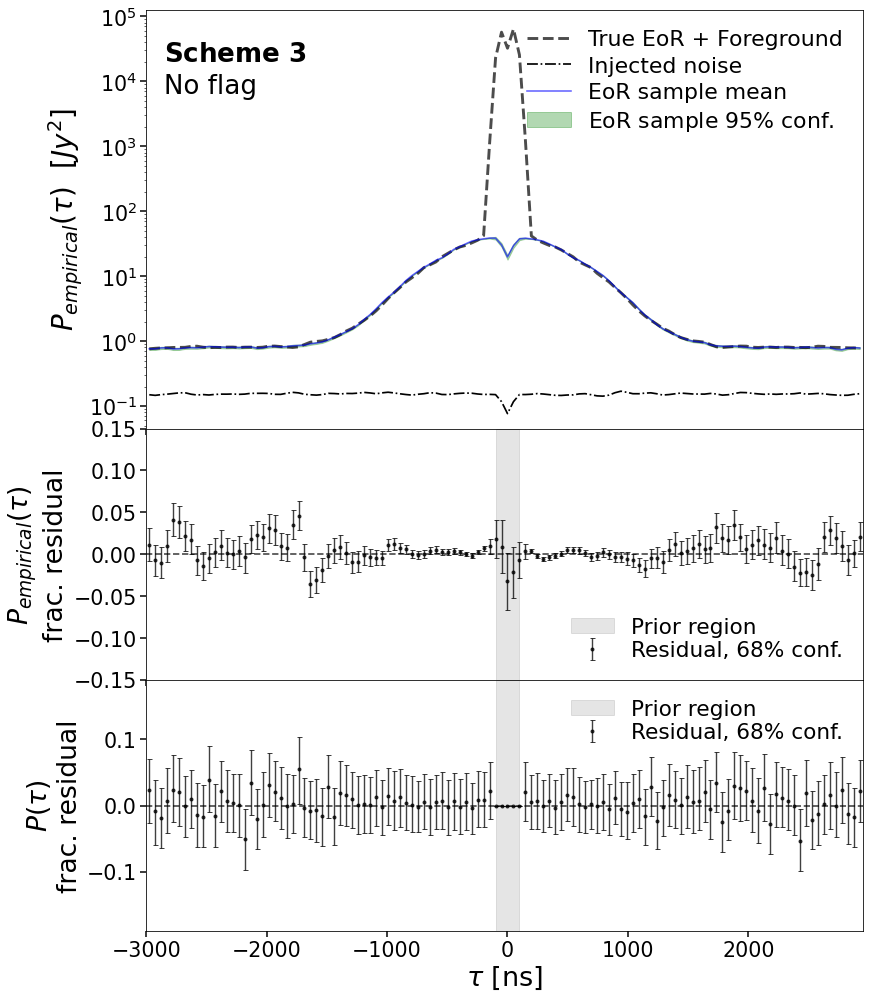

In [398]:
Niter=800
# flagtag = '5% random flag'
flagtag = 'No flag'
# flagtag = '5% continuous flag'
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,14), sharex=True, gridspec_kw={'hspace':0, 'height_ratios':[1,0.6,0.6]})

fsb = 8.1
lwb = 0.5

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(crs_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')

# ax2.plot(tau_f*1e3, (cr_0/tps)-1, 'k-', alpha=0.75, lw=1.8+lwb, label='Residual mean')
# ax2.plot(tau_f*1e3, (cr_p2/tps)-1, 'k--', alpha=0.5, lw=1+lwb, label=r'95$\%$ conf.')
# ax2.plot(tau_f*1e3, (cr_m2/tps)-1, 'k--', alpha=0.5, lw=1+lwb)

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

# ax3.plot(tau_f*1e3, (cr_0_/pst_)-1, 'k-', alpha=0.75, lw=1.8+lwb, label='Residual mean')
# ax3.plot(tau_f*1e3, (cr_p2_/pst_)-1, 'k--', alpha=0.5, lw=1+lwb, label=r'95$\%$ conf.')
# ax3.plot(tau_f*1e3, (cr_m2_/pst_)-1, 'k--', alpha=0.5, lw=1+lwb)

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=13.9+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower right')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='upper right')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6, width=1.5,  labelsize=12.5+fsb)

ax1.text(-2850,2e4, r'$\bf{Scheme~3}$', fontsize=18+fsb)
ax1.text(-2850,6.45e3, flagtag, fontsize=18+fsb)

ax1.set_ylabel(r'$P_{empirical}(\tau) ~~[Jy^2]$', fontsize=19.5+fsb)
ax2.set_ylabel(r'$P_{empirical}(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax3.set_ylabel(r'$P(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6, width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)
plt.tight_layout()

# plt.savefig('figs/Gibbs/5r-5-jt.pdf')

ax1.set_ylim( 4.5e-2, None)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)
plt.savefig('figs/Gibbs/5r-5-jt.pdf')

In [226]:
# # Zscores
# fig, ax = plt.subplots(figsize=(7,5))
# zscores =  (cr_0_-pst_)/sigma_est 
# # grvs = np.random.randn(len(zscores))
# zbins = np.linspace(-10,10,100)
# plt.plot(zbins,np.exp(-0.5*zbins**2)/2)
# plt.hist(zscores[np.isfinite(zscores)], bins=zbins,label='run zscores', histtype='step', ls='--',density=True)[2]
# # plt.xlim(-10,10)
# plt.legend()

In [396]:
name = 'run21'
savfol = 'Gibbs-joint-runs/'
crs_store = np.load(savfol+'crs-'+name+'.npy')
crf_store = np.load(savfol+'crf-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
tps = np.mean(pSsig, axis=0).real
pSnoise = naivePS(noiseS)

In [352]:
# ip=200
# it=3
# plt.plot(bl[ip], label='bl')
# plt.plot(signaltouse[ip], label='truesig')

# plt.plot(crs_store[it,ip,:], label='cr', ls='--')
# plt.plot(crf_store[it,ip,:], label='crf', ls='--')

# plt.legend()
# signaltouse.shape


In [14]:
# array resizing to cut off unused zeros
Niter = 3000
np.save(savfol+'crs-'+name+'.npy',crs_store[:Niter,:,:])
np.save(savfol+'crf-'+name+'.npy',crf_store[:Niter,:,:])
np.save(savfol+'S-'+name+'.npy',S_store[:Niter,:,:])
np.save(savfol+'ds-'+name+'.npy',ds_store[:Niter,:])

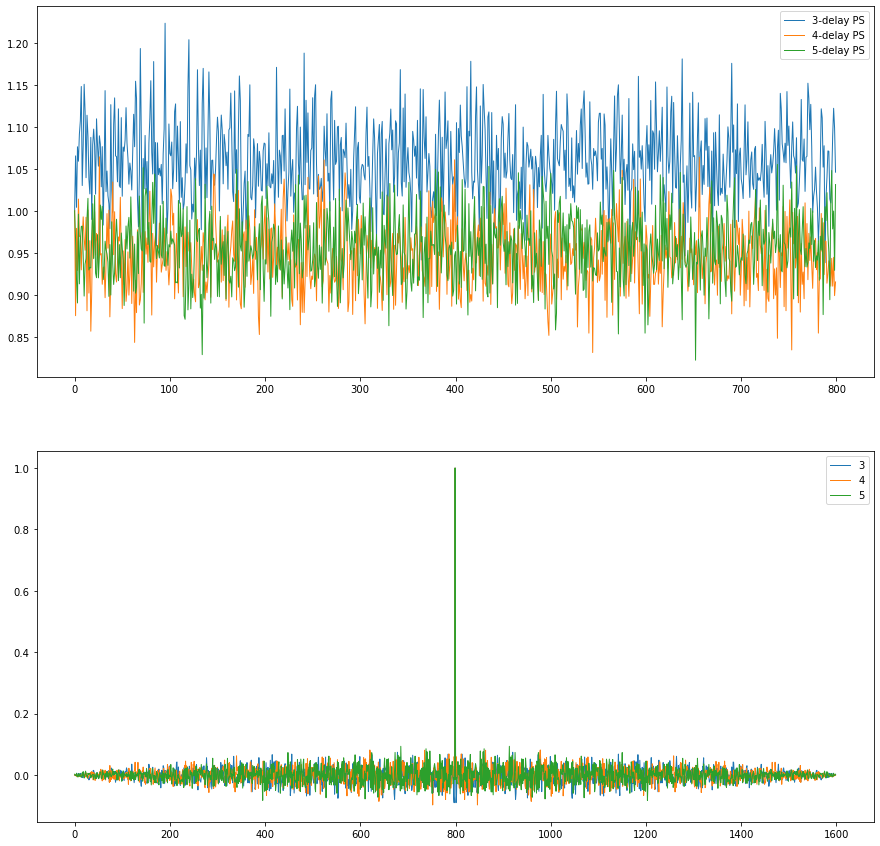

In [87]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
traceidx =0
for idx in [3,4,5]:
    trace = ds_store[:Niter,idx]
    ax1.plot(trace/trace[0], label='%d-delay PS'%idx, lw=1)
    corr = np.correlate(trace-np.mean(trace),trace-np.mean(trace), mode='full')
    ax2.plot(corr/max(corr), label='%d'%idx, lw=1)
    
# plt.plot(np.sum(crf_store[:,:,1], axis=1), label='fg amp')
# plt.yscale('log')
# plt.yscale('log')
ax1.legend()
ax2.legend()

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


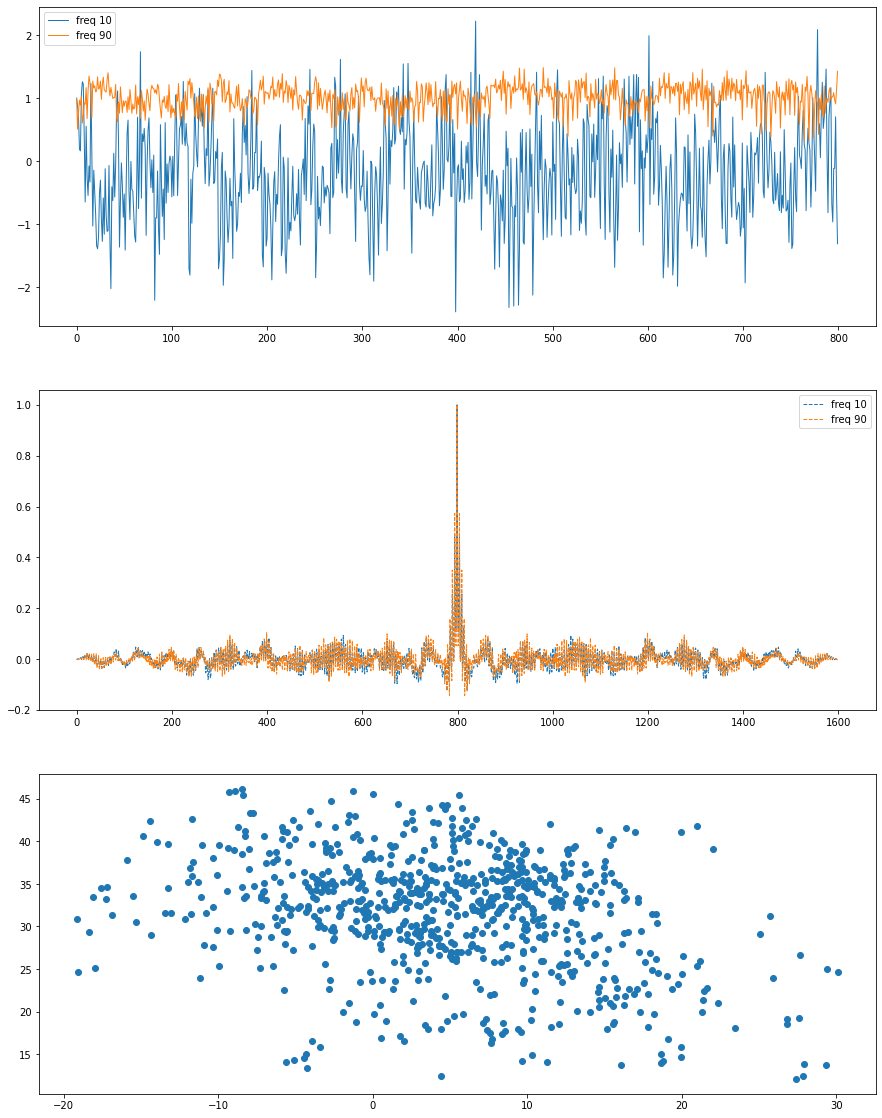

In [88]:
# signal/foregrounds
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
traceidx =0
traces = []
idxs = [10,90]
for idx in idxs:
    traces.append(np.sum(crs_store[:Niter,:,idx],axis=1)) 
for i,trace in enumerate(traces):
    ax1.plot(trace/trace[0], label='freq %d'%idxs[i], lw=1)
    corr = np.correlate(trace-np.mean(trace),trace-np.mean(trace), mode='full')
    ax2.plot(corr/max(corr), label='freq %d'%idxs[i], lw=1, ls='--')
    

ax3.scatter(traces[0],traces[1])
# plt.plot(np.sum(crf_store[:,:,1], axis=1), label='fg amp')
# plt.yscale('log')
# plt.yscale('log')
ax1.legend()
ax2.legend()

Casting complex values to real discards the imaginary part


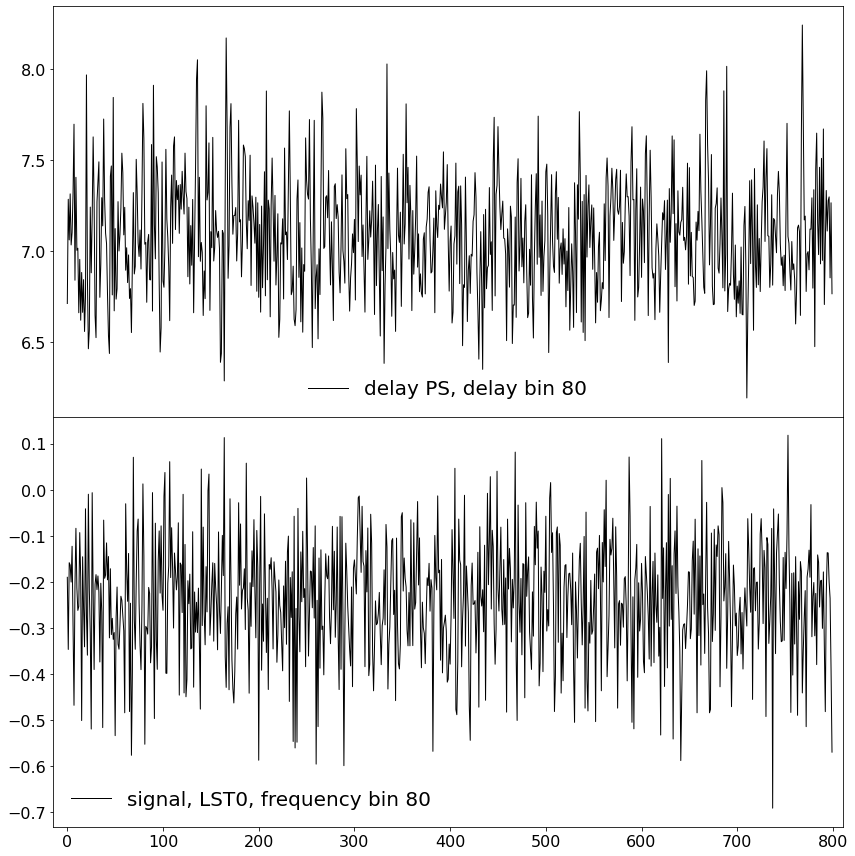

In [135]:
# trace plots to determine where it has converged
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,12), sharex=True, gridspec_kw={'hspace':0})
tidx =80
dtrace = ds_store[:Niter,tidx]
ax1.plot(dtrace,  'k-', label='delay PS, delay bin %d'%tidx, lw=1)
strace = crs_store[:Niter,0,tidx]
ax2.plot(strace, 'k-', label='signal, LST0, frequency bin %d'%tidx, lw=1)
ax1.legend(fontsize=20, frameon=False)
ax2.legend(fontsize=20, frameon=False)
for ax in [ax1,ax2]:
    ax.tick_params(labelsize=16)
ax1.set_xlim(-15,810)
plt.tight_layout()
plt.savefig('figs/Gibbs/5r-5-800jt-trace.pdf')

In [103]:
ds_store.shape

(800, 120)

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


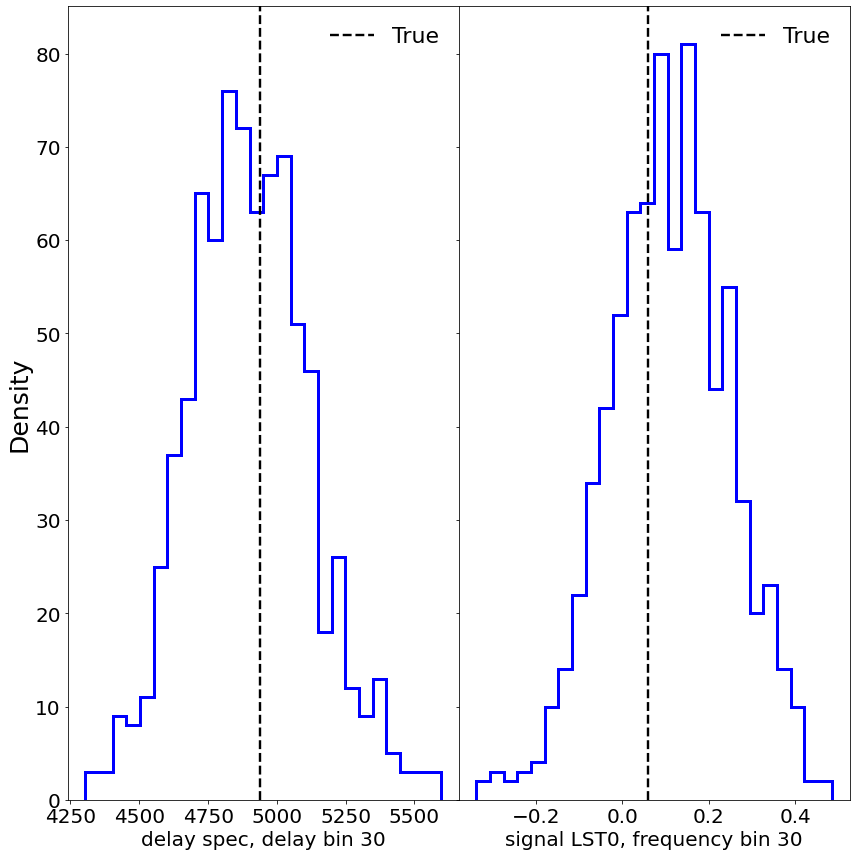

In [134]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12), sharey=True, gridspec_kw={'wspace':0})
pst__ = nPS(signaltouse)
binidx = 30

ddist = ax1.hist(ds_store[:Niter,binidx]*599, bins=26, histtype='step', lw=3, color='b')[2] 
ax1.axvline(pst__[binidx], c='k', ls='--',lw=2.4, label='True')
sdist = ax2.hist(crs_store[:Niter,0,binidx], bins=26, histtype='step', lw=3, color='b')[2]
ax2.axvline(signaltouse[0,binidx], c='k', ls='--',lw=2.4, label='True')
for ax in [ax1,ax2]:
    ax.tick_params(labelsize=20)
    ax.legend(fontsize=22, frameon=False)
ax1.set_xlabel('delay spec, delay bin %d'%binidx, fontsize=20)
ax2.set_xlabel('signal LST0, frequency bin %d'%binidx, fontsize=20)
ax1.set_ylabel('Density', fontsize=25)
plt.tight_layout()
plt.savefig('figs/Gibbs/5r-5-800jt-dists.pdf')

In [1100]:
fullvars = np.concatenate( (  ds_store,np.sum(crs_store,axis=1),np.sum(crf_store,axis=1)), axis=-1)

fullvars = np.concatenate( (  ds_store,crs_store[:,0,:],crf_store[:,0,:]), axis=-1)





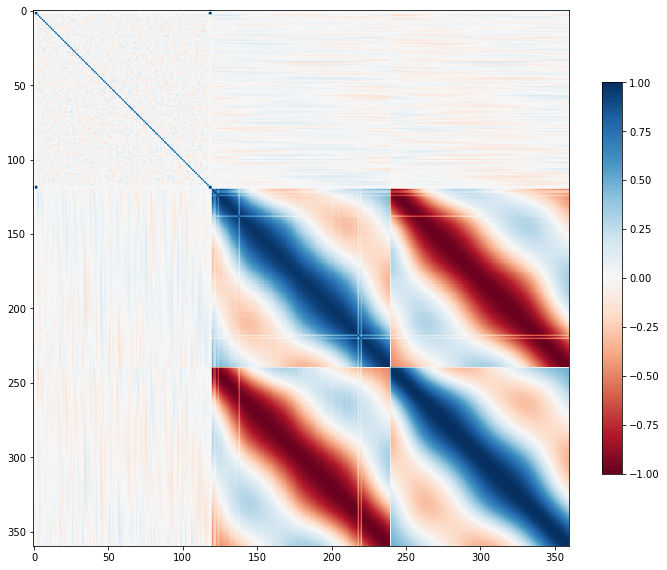

In [1101]:
fullvarscov = np.cov( fullvars.T )

fullvarscorr = np.zeros((3*s,3*s),dtype=complex)

for i in range(3*s):
    for j in range(3*s):
        fullvarscorr[i,j] = fullvarscov[i,j]/(fullvarscov[i,i]*fullvarscov[j,j])**0.5
        
fig, ax = plt.subplots(figsize=(12,12))
        
plt.imshow( fullvarscorr.real , cmap='RdBu')
plt.colorbar(shrink=0.6)

Casting complex values to real discards the imaginary part


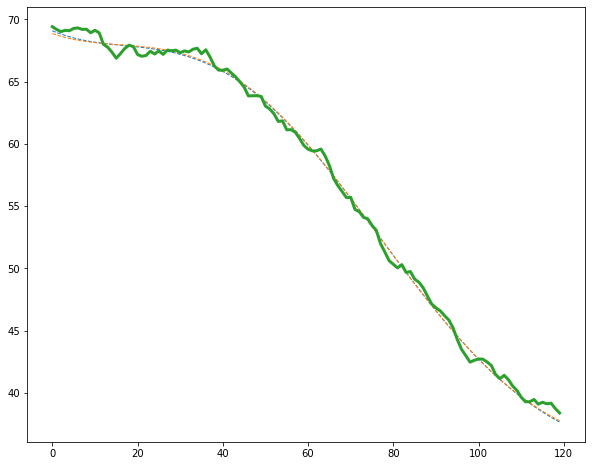

In [394]:
fig, ax = plt.subplots(figsize=(10,8))
for i in [528,529]:
    plt.plot(crf_store[i,400,:].real, lw=1, ls='--')

plt.plot(Vis_noise[400], lw=3)

In [981]:
# crt = cr_store[:,0,:] # iteration, LST, frequency
# print(crt.shape)
# plt.plot(crt.T.real)

In [982]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,11))
# ds_store.shape
# np.sum(amp_store, axis=1).shape
# covmax = 1e50
# im = ax1.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).real, cmap='RdBu', vmin=-1*covmax, vmax=covmax)
# im2 = ax2.matshow(np.cov(ds_store.T, np.sum(amp_store, axis=1).T).imag, cmap='RdBu', vmin=-1*covmax, vmax=covmax)

# plt.colorbar(im, ax=ax1, shrink=0.6)
# plt.colorbar(im2, ax=ax2, shrink=0.6)

## Fitting the amplitudes of basis vectors - 

### 1. why does this work?



(120, 8)


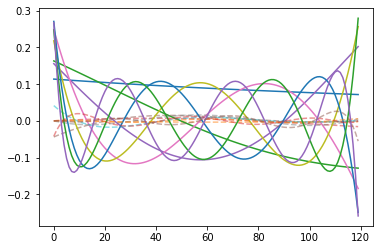

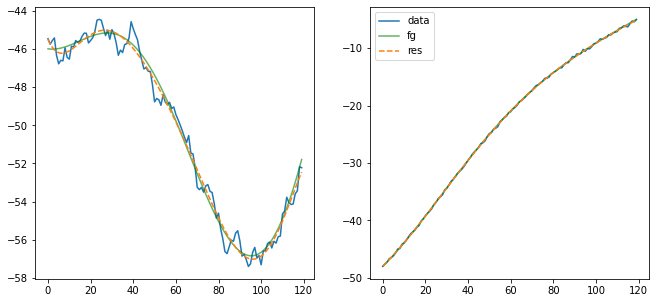

7.564133094582144e-05


(-0.1, 0.1)

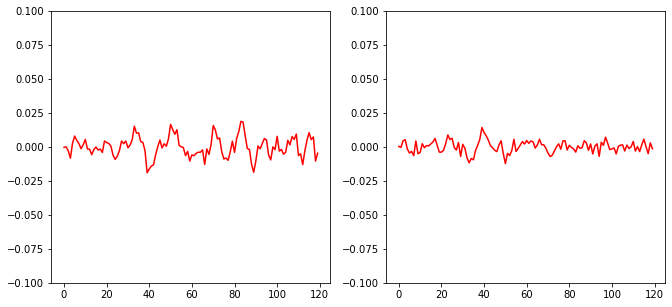

In [80]:
Sevals, Sevs = np.linalg.eig(C_f)
Nf = 8
F = Sevs[:,:Nf]


print(F.shape)
for i in range(Nf):
    plt.plot(F[:,i].real)
    plt.plot(F[:,i].imag, ls='--', alpha=0.5)

k = 1100
dt = Vis_noise[k]

Fdt = F.T.conj() @ dt   #what exactly is this operation doing? expressing dt in the basis F?

FdtF = Fdt @ F.T

plt.show()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))
ax1.plot(dt.real, label='data')
ax1.plot(bl[k].real, label='fg', alpha=0.6,c='g')
ax1.plot(FdtF.real, label='res', ls='--')
ax2.plot(dt.imag, label='data')
ax2.plot(bl[k].imag, label='fg', alpha=0.6,c='g')
ax2.plot(FdtF.imag, label='res', ls='--')
plt.legend()
plt.show()


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))

ax1.plot((1 - FdtF/dt).real, 'r-')
ax2.plot((1 - FdtF/dt).imag, 'r-')
print(np.var((1 - FdtF/dt)))
flim = 1e-1
ax1.set_ylim(-flim,flim)
ax2.set_ylim(-flim,flim)

In [ ]:
new = ((F.T.conj()  @  Vft.T).T @ F.T)
pnew = np.mean(naivePS(Vft-new, meansub=1, taper=1),axis=0)

new_noise = ((F.T.conj()  @  Vis_noise.T).T @ F.T)
pnew_noise = np.mean(naivePS(Vis_noise-new, meansub=1, taper=1),axis=0)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax1.plot(pnew, label='fg subtracted')
# plt.plot( np.mean(naivePS(  meansub=1, taper=1 ) )  )
ax1.plot(np.mean(pS, axis=0), ls='--', label='true')
# plt.plot(np.mean(pSdata, axis=0), ls='--')
ax1.set_yscale('log')
ax1.legend(fontsize=12)
ax2.plot(pnew_noise)
# plt.plot( np.mean(naivePS(  meansub=1, taper=1 ) )  )
ax2.plot(np.mean(pS, axis=0), ls='--')
# plt.plot(np.mean(pSdata, axis=0), ls='--')
ax2.set_yscale('log')
ax2.set_ylim(5e-2,8e6)
ax1.set_title('no noise')
ax2.set_title('including noise')

In [ ]:
k = 1100
plt.plot(new[k].real)
plt.plot(bl[k].real)

In [ ]:
(N@F).shape

In [964]:
tsss = crs_store[101]

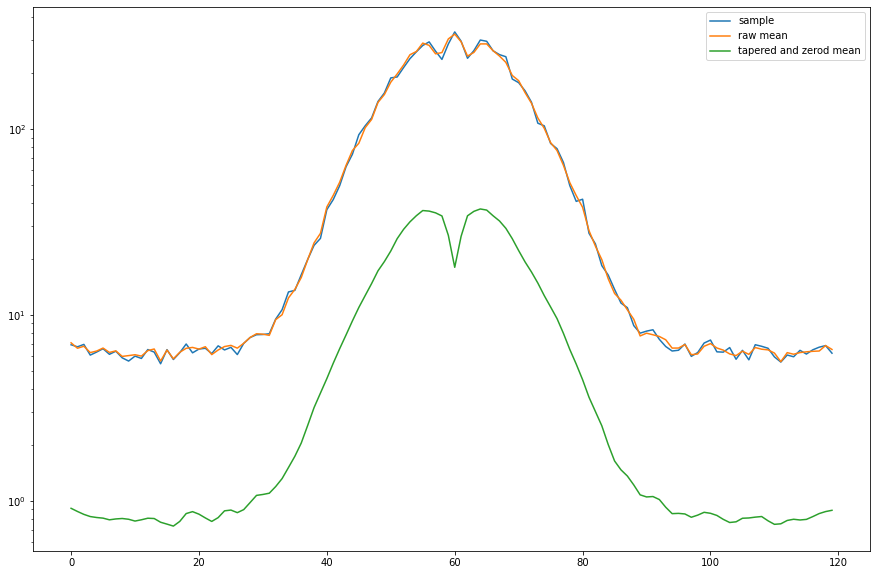

In [987]:
# my calc
dsc_ = np.mean(naivePS(tsss),axis=0).real

# prior calculation
sk_ = np.fft.fft(tsss, axis=-1)
ds_ = np.sum(sk_ * sk_.conj(), axis=0).real
dssample = sample_S(s=tsss)

fig, ax = plt.subplots(figsize=(15,10))
plt.plot(flip(dssample), label='sample')
plt.plot(flip(ds_)/599, label='raw mean')

plt.plot(dsc_, label='tapered and zerod mean')
plt.yscale('log')
plt.legend()

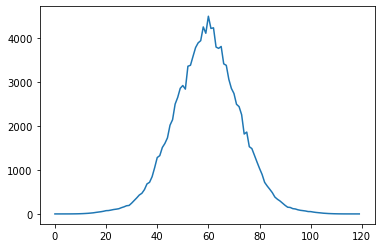

In [985]:
sk_mm = (sk_ - np.mean(sk_,axis=1)[:,np.newaxis])*BH(s)
# sk_mm = sk_ - np.mean(sk_,axis=0)

plt.plot(np.sum(sk_mm*sk_mm.conj(), axis=0).real)



In [ ]:
# beta = np.sum(sk * sk.conj(), axis=0).real 

# alpha = Nobs/2. - 1.

# x = np.zeros(Nfreqs)
# for i in range(Nfreqs):
#     x[i] = invgamma.rvs(a=alpha) * beta[i] # y = x / beta



In [ ]:
# psn_ = flip(nPS(noiseS))
# pst_ = flip(nPS(signaltouse))
# psf_ = flip(nPS(signaltouse+bl))
# Niter=800


# fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,14), sharex=True, gridspec_kw={'hspace':0})
# colors = plt.cm.cool(np.linspace(0,1,Niter))

# ps_ = np.zeros((Niter,s))

# for i in range(Niter):
# #     ps_[i] = flip(nPS(crs_store[i]))                                         # crs
#     ps_[i] = flip(ds_store[i])*599                                             # delay spec sample
    
# cr_0_ = np.mean(ps_, axis=0)
# cr_p1_ = np.percentile(ps_, 84.2, axis=0)
# cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
# cr_p2_ = np.percentile(ps_, 98.6, axis=0)
# cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

# mresid = (cr_0_/pst_)-1

# ax1.plot(tau_f*1e3, psf_, 'g--', lw=2, label='+fg')
# ax1.plot(tau_f*1e3, cr_0_, 'b-', alpha=0.7, lw=1.8, label='mean')

# # ax2.plot(tau_f*1e3, mresid, 'k-', alpha=0.7, lw=1.8, label='residual mean')
# # ax2.plot(tau_f*1e3, mresid+((cr_p1_/pst_)-1)/Niter**0.5, 'k--', alpha=0.6, lw=1.4, label=r'$1\sigma$-mean') 
# # ax2.plot(tau_f*1e3, mresid+((cr_p2_/pst_)-1)/Niter**0.5, 'k-.', alpha=0.5, lw=1, label=r'2$\sigma$-mean')
# # ax2.plot(tau_f*1e3, mresid+((cr_m1_/pst_)-1)/Niter**0.5, 'k--', alpha=0.6, lw=1.4)    # and attach to the mean, plot errorbars
# # ax2.plot(tau_f*1e3, mresid+((cr_m2_/pst_)-1)/Niter**0.5, 'k-.', alpha=0.5, lw=1)

# ax2.plot(tau_f*1e3, mresid, 'k-', alpha=0.7, lw=1.8, label='residual mean')
# ax2.plot(tau_f*1e3, mresid+((cr_p1_/pst_)-1), 'k--', alpha=0.6, lw=1.4, label=r'$1\sigma$-mean') 
# ax2.plot(tau_f*1e3, mresid+((cr_p2_/pst_)-1), 'k-.', alpha=0.5, lw=1, label=r'2$\sigma$-mean')
# ax2.plot(tau_f*1e3, mresid+((cr_m1_/pst_)-1), 'k--', alpha=0.6, lw=1.4)    # and attach to the mean, plot errorbars
# ax2.plot(tau_f*1e3, mresid+((cr_m2_/pst_)-1), 'k-.', alpha=0.5, lw=1)

# # ax2.plot(tau_f*1e3, mresid, 'k-', alpha=0.7, lw=1.8, label='residual mean')
# # ax2.plot(tau_f*1e3, (cr_p1_/pst_)-1, 'k--', alpha=0.6, lw=1.4, label=r'$1\sigma$') # 
# # ax2.plot(tau_f*1e3, (cr_p2_/pst_)-1, 'k-.', alpha=0.5, lw=1, label=r'2$\sigma$')
# # ax2.plot(tau_f*1e3, (cr_m1_/pst_)-1, 'k--', alpha=0.6, lw=1.4)
# # ax2.plot(tau_f*1e3, (cr_m2_/pst_)-1, 'k-.', alpha=0.5, lw=1)

# sigma_est = (cr_p1_ - cr_m1_)/2
# # sigma_est = (cr_p1_ - cr_m1_)/2 /Niter**0.5

# ax3.scatter(tau_f*1e3,  (cr_0_-pst_)/sigma_est, marker='+',c='k' )

# ax1.plot(tau_f*1e3, psn_, 'b--', label='noise only')
# ax1.plot(tau_f*1e3, pst_, 'k--', label='empirical ps', lw=3)

# ax1.legend()
# ax1.set_yscale('log')
# ax2.axhline(0, c='k', ls='--')
# for ax in [ax1,ax2]:
#     ax.set_xlim(-3e3, 3e3)
# ax3.axhline(0, c='k', ls='--')

# # ax1.text(-2700,1e6, '5% continuous flag', fontsize=19)
# # ax3.set_ylim(-4,4)
# ax3.set_ylabel('Z-score', fontsize=14)

# ax2.set_ylabel('fractional residual', fontsize=14)
# ax2.set_xlabel(r'$\tau$ [$\mu$s]', fontsize=14)
# ax2.set_ylim(-0.2,0.2)
# ax2.legend(frameon=False, fontsize=14)
# ax1.tick_params(labelbottom=False)

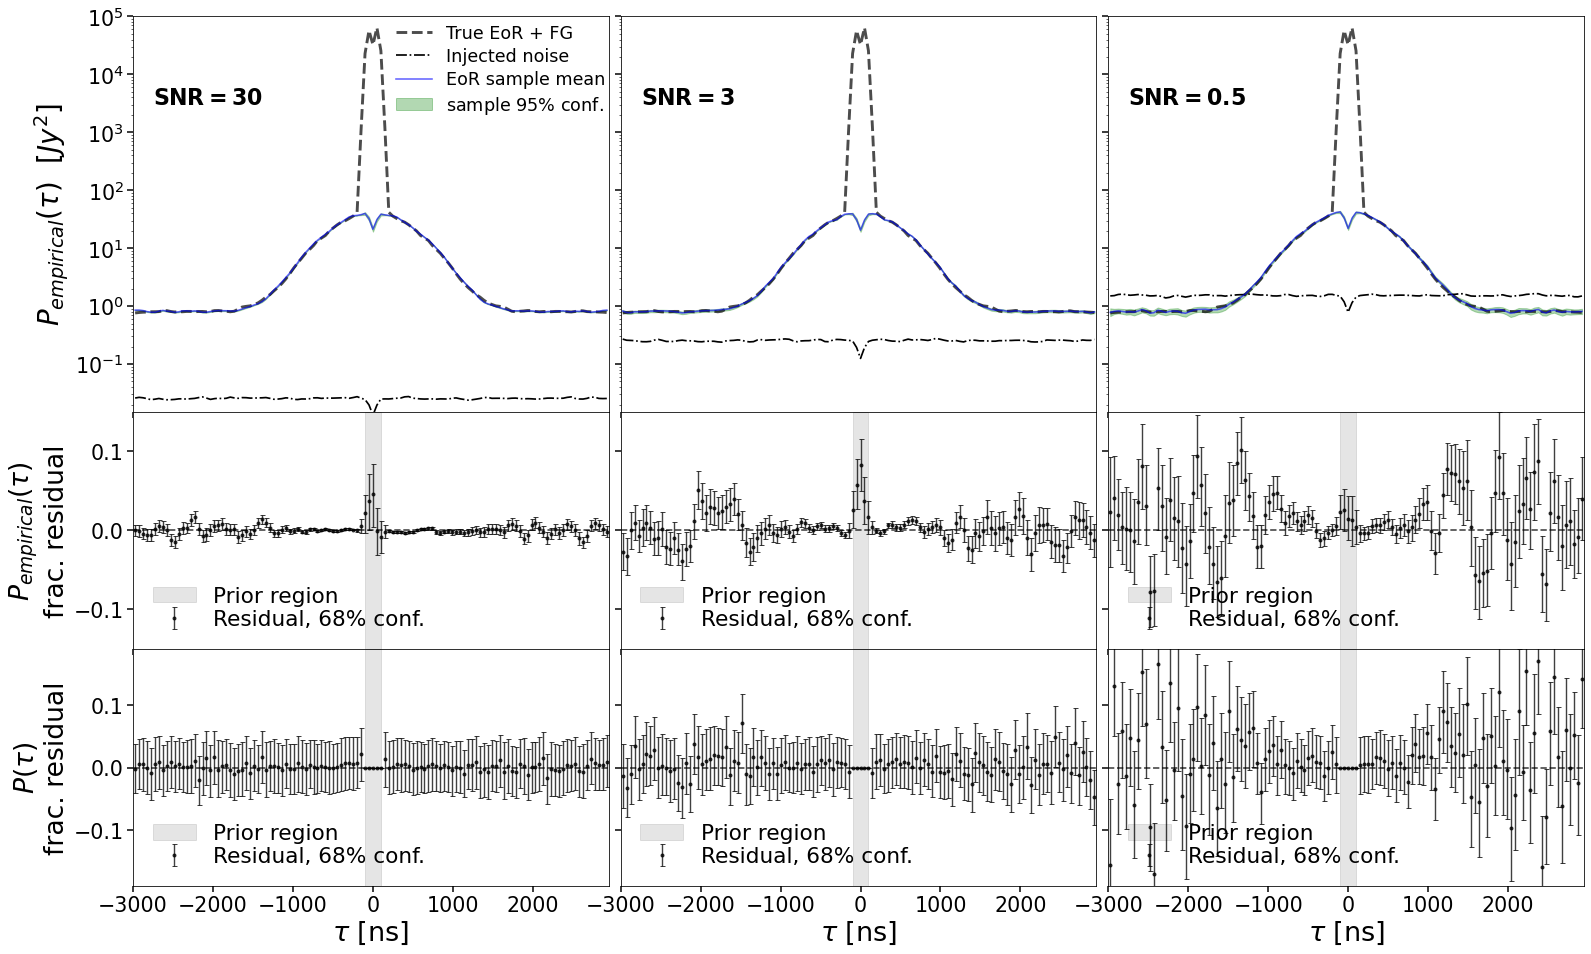

In [392]:
# BIG TRIPLE FIGURE COMPARISON
fig, axs = plt.subplots(3,3,figsize=(26,16), sharex=True, gridspec_kw={'hspace':0, 'wspace':0.025,'height_ratios':[1,0.6,0.6]})
ylb, ylt = 1.5e-2, 1e5
ax1 = axs[0,0]
ax2 = axs[1,0]
ax3 = axs[2,0]

name = 'run22'
savfol = 'Gibbs-joint-runs/'
cr_store = np.load(savfol+'crs-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{SNR = 30}$'

fsb = 8.1
lwb = 0.5

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + FG', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'sample 95$\%$ conf.')

erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.legend(frameon=False, fontsize=9.5+fsb, labelspacing=0.3, bbox_to_anchor=(0.52,1.02))
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6, width=1.5, labelsize=12.5+fsb)

ax1.text(-2750,3e3, flagtag, fontsize=14+fsb)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)

ax1.set_ylabel(r'$P_{empirical}(\tau) ~~[Jy^2]$', fontsize=19.5+fsb)
ax2.set_ylabel(r'$P_{empirical}(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax3.set_ylabel(r'$P(\tau)$' +'\n' + 'frac. residual', fontsize=18.5+fsb)
ax1.set_ylim(ylb, ylt)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6, width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)



name = 'run23'
savfol = 'Gibbs-joint-runs/'
cr_store = np.load(savfol+'crs-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{SNR = 3}$'

ax1 = axs[0,1]
ax2 = axs[1,1]
ax3 = axs[2,1]

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')


erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')

erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

# ax1.legend(frameon=False, fontsize=14.5+fsb, labelspacing=0.3, loc='upper right')
ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6, width=1.5, labelsize=12.5+fsb, labelleft=False)

ax1.text(-2750,3e3, flagtag, fontsize=14+fsb)

ax1.set_ylim(ylb, ylt)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6, width=1.5,  labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)

name = 'run24'
savfol = 'Gibbs-joint-runs/'
cr_store = np.load(savfol+'crs-'+name+'.npy')
S_store = np.load(savfol+'S-'+name+'.npy')
ds_store = np.load(savfol+'ds-'+name+'.npy')
signaltouse = np.load(savfol+'truesigs-'+name+'.npy')
noiseS = np.load(savfol+'noise-'+name+'.npy')
pSsig = naivePS(signaltouse)
pSnoise = naivePS(noiseS)

Niter=800
flagtag = r'$\bf{SNR = 0.5}$'

ax1 = axs[0,2]
ax2 = axs[1,2]
ax3 = axs[2,2]

pst_ = flip(nPS(signaltouse)) # delay spec truth, untapered delay spectrum
tps = np.mean(pSsig, axis=0).real # crs truth, tapered mean subbed average

ps = np.zeros((Niter,s))
ps_ = np.zeros((Niter,s))

for i in range(Niter):
    ps[i] =  np.mean( naivePS(cr_store[i], meansub=1, taper=1), axis=0).real
    ps_[i] = flip(ds_store[i])*(Np/2.-1.)                                           # delay spec sample

# crs
cr_0 = np.mean(ps, axis=0)
cr_p1 = np.percentile(ps, 84.2, axis=0)
cr_m1 = np.percentile(ps, 100-84.2, axis=0)
cr_p2 = np.percentile(ps, 98.6, axis=0)
cr_m2 = np.percentile(ps, 100-98.6, axis=0)
# delay spectrum
cr_0_ = np.mean(ps_, axis=0)
cr_p1_ = np.percentile(ps_, 84.2, axis=0)
cr_m1_ = np.percentile(ps_, 100-84.2, axis=0)
cr_p2_ = np.percentile(ps_, 98.6, axis=0)
cr_m2_ = np.percentile(ps_, 100-98.6, axis=0)

ax1.plot(tau_f*1e3, np.mean(pS, axis=0), 'k--', label='True EoR + Foreground', alpha=0.7, lw=2.4+lwb)
ax1.plot(tau_f*1e3, np.mean(pSnoise, axis=0), 'k-.', label='Injected noise', lw=1.2+lwb)
ax1.plot(tau_f*1e3, cr_0, 'b-', alpha=0.6, lw=1.1+lwb, label='EoR sample mean')
ax1.fill_between(tau_f*1e3, cr_m2, cr_p2, color='g', alpha=0.3, label=r'EoR sample 95$\%$ conf.')


erbar = np.zeros((2,120))
erbar[0], erbar[1] = ((cr_0/tps)-1)-((cr_m1/tps)-1), ((cr_p1/tps)-1)-((cr_0/tps)-1)
ax2.errorbar(tau_f*1e3, (cr_0/tps)-1, yerr=erbar ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


erbar_ = np.zeros((2,120))
erbar_[0], erbar_[1] = ((cr_0_/pst_)-1)-((cr_m1_/pst_)-1), ((cr_p1_/pst_)-1)-((cr_0_/pst_)-1)
ax3.errorbar(tau_f*1e3, (cr_0_/pst_)-1, yerr=erbar_ ,c='k', alpha=0.75, lw=1.8+lwb,\
             label='Residual, 68% conf.', elinewidth=0.9+lwb, capsize=2.5, fmt='.')


ax2.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')
ax3.axvspan(tau_f[58]*1e3, tau_f[62]*1e3, color='k', alpha=0.1, label='Prior region')

ax1.set_yscale('log')
ax2.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
ax3.axhline(0, c='k', ls='--', lw=1.2+lwb, alpha=0.7)
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3e3, 2.95e3)
    ax.tick_params(length=6, width=1.5, labelsize=12.5+fsb, labelleft=False)

ax2.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
ax3.legend(frameon=False, fontsize=13.5+fsb, labelspacing=0.15, loc='lower left')
    
ax1.text(-2750,3e3, flagtag, fontsize=14+fsb)
# ax1.text(-2850,2e2, r'$\bf{15Jy~point~source~cut}$', fontsize=15+fsb)

ax1.set_ylim(ylb, ylt)
ax2.set_ylim(-0.15,0.15)
ax3.set_ylim(-0.19,0.19)
ax1.tick_params(length=6, width=1.5, labelbottom=False)
ax3.set_xlabel(r'$\tau$ [ns]', fontsize=19+fsb)

# plt.tight_layout()
plt.savefig('figs/Gibbs/noise-jt-comparison.pdf', bbox_inches='tight')